## Homework №3

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip install nltk
# ! pip install torchtext

In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/home/xfs/.wget-hsts'. HSTS will be disabled.
File ‘data.txt’ already there; not retrieving.



In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer

In [4]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [5]:
tokenizer_W = WordPunctTokenizer()

def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [6]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [7]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [8]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [9]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

PAD_IDX = TRG.vocab.stoi['<pad>']

In [10]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9240
Unique tokens in target (en) vocabulary: 6717


Here are tokens from original (RU) corpus:

In [11]:
SRC.vocab.itos[::1000]

['<unk>',
 'еду',
 'baan',
 'лаунджа',
 '78',
 'шанхайского',
 'maya',
 'утесе',
 'дискотеки',
 'тенистом']

And from target (EN) corpus:

In [12]:
TRG.vocab.itos[::1000]

['<unk>', 'roof', 'limassol', 'dali', 'mintue', 'siro', 'marken']

And here is example from train dataset:

In [13]:
print(vars(train_data.examples[9]))

{'trg': ['kansas', 'city', 'airport', 'is', '82', 'km', 'away', '.'], 'src': ['расстояние', 'до', 'аэропорта', 'канзас', '-', 'сити', 'составляет', '82', 'км', '.']}


Let's check the length distributions:

Length distribution in Train data


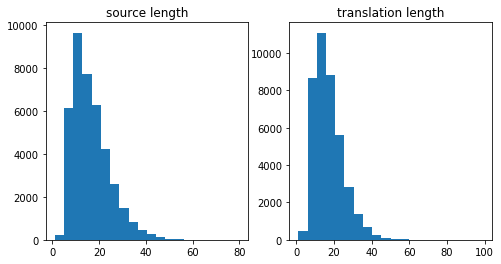

In [14]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

In [15]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

# print('Length distribution in Test data')
# plt.figure(figsize=[8, 4])
# plt.subplot(1, 2, 1)
# plt.title("source length")
# plt.hist(list(src_length), bins=20);

# plt.subplot(1, 2, 2)
# plt.title("translation length")
# plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
device

device(type='cuda')

In [18]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [19]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 42x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 45x128 (GPU 0)]
torch.Size([45, 128]) torch.Size([42, 128])


In [20]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [22]:
def train(
    model,
    iterator,
    optimizer,
    scheduler,
    criterion,
    clip,
    train_history=None,
    valid_history=None,
    valid_bleu_history=None
):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        if scheduler is not None:
            scheduler.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            ax[1].set_title('Loss')
            ax[2].set_title('Valid BLEU')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            ax[1].legend()
            if valid_bleu_history is not None:
                ax[2].set_xlabel('Epoch')
                ax[2].plot(valid_bleu_history, label='valid bleu history')
            plt.show()

        
    return epoch_loss / len(iterator)

In [23]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    history = []
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg
            output = model(src, trg, 0) #turn off teacher forcing
            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)
            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [24]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [25]:
import tqdm
from nltk.translate.bleu_score import corpus_bleu
#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

def calculate_bleu(model, test_iterator):
    original_text = []
    generated_text = []
    model.eval()
    with torch.no_grad():

        for i, batch in tqdm.tqdm(enumerate(test_iterator)):
            src = batch.src
            trg = batch.trg
            output = model(src, trg, 0) #turn off teacher forcing
            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output.argmax(dim=-1)
            original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
            generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

    # original_text = flatten(original_text)
    # generated_text = flatten(generated_text)

    return corpus_bleu([[text] for text in original_text], generated_text) * 100

In [26]:
def run_train_loop(
    n_epochs,
    clip,
    model,
    train_iterator,
    valid_iterator,
    optimizer,
    criterion,
    model_save_path,
    scheduler=None
):
    train_history = []
    valid_history = []
    valid_bleu_history = [] 
    best_valid_bleu = 0

    for epoch in range(n_epochs):
        start_time = time.time()

        train_loss = train(
            model,
            train_iterator,
            optimizer,
            scheduler,
            criterion,
            clip,
            train_history,
            valid_history,
            valid_bleu_history
        )
        valid_loss = evaluate(model, valid_iterator, criterion)
        valid_bleu = calculate_bleu(model, valid_iterator)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_bleu > best_valid_bleu:
            best_valid_bleu = valid_bleu
            torch.save(model.state_dict(), model_save_path)

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        valid_bleu_history.append(valid_bleu)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        print(f'\t Val. BLEU: {valid_bleu:.3f}')

    return train_history, valid_history, valid_bleu_history

In [27]:
import baseline_model

INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = baseline_model.Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = baseline_model.Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = baseline_model.Seq2Seq(enc, dec, device).to(device)
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9240, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6717, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6717, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [28]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,887,229 trainable parameters


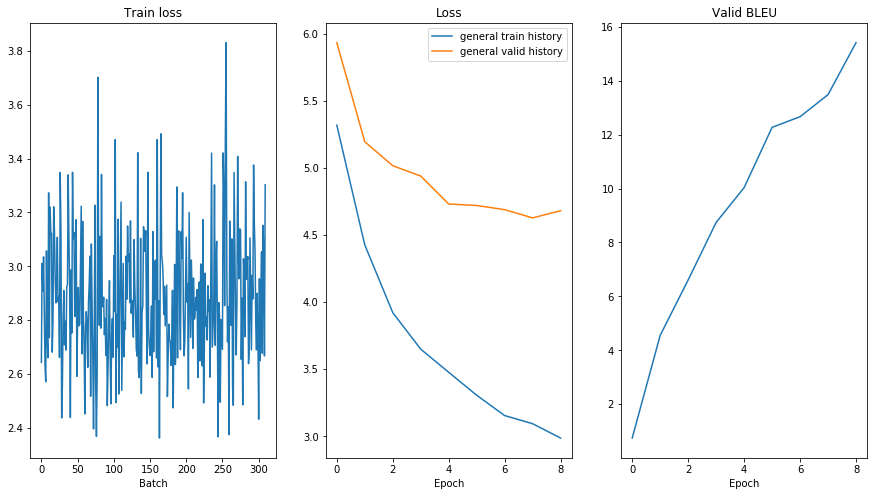

20it [00:00, 20.70it/s]


Epoch: 10 | Time: 1m 20s
	Train Loss: 2.882 | Train PPL:  17.845
	 Val. Loss: 4.601 |  Val. PPL:  99.612
	 Val. BLEU: 15.781


In [29]:
LR = 1e-3
N_EPOCHS = 10
CLIP = 1
MODEL_SAVE_PATH = 'LSTM.pth'

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

train_history, valid_history, valid_bleu_history = run_train_loop(
    N_EPOCHS,
    CLIP,
    model,
    train_iterator,
    valid_iterator,
    optimizer,
    criterion,
    MODEL_SAVE_PATH
)

In [30]:
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

__Let's take a look at our network quality__:

In [31]:
batch = next(iter(test_iterator))

In [32]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: you will find a 24 - hour front desk at the property .
Generated: the 24 - hour front desk .

Original: a hairdryer can be requested .
Generated: room and a hairdryer are provided .



In [33]:
calculate_bleu(model, test_iterator)

59it [00:02, 20.71it/s]


15.291422386159764

Baseline solution BLEU score is quite low. Try to achieve at least __18__ BLEU on the test set. 
The checkpoints are:

* __18__ - minimal score to submit the homework, 30% of points

* __20__ - good score, 70% of points

* __25__ - excellent score, 100% of points

In [34]:
from my_models import GRU_Encoder, CNN_Encoder, \
    GRU_Decoder, GRU_Decoder_With_Attention, Seq2Seq

### 1. GRU encoder + GRU encoder

Let's rewrite baseline to use GRU intstead of LSTM, also we'll add OneCycleLR scheduler to train loop.

We will choose the best model checkpoint by BLEU on validation.

In [35]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
GRU_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = GRU_Encoder(
    INPUT_DIM,
    ENC_EMB_DIM,
    HID_DIM,
    GRU_LAYERS,
    p=ENC_DROPOUT
)

dec = GRU_Decoder(
    OUTPUT_DIM,
    DEC_EMB_DIM,
    HID_DIM,
    GRU_LAYERS,
    p=DEC_DROPOUT
)

model = Seq2Seq(enc, dec, device).to(device)
model.apply(init_weights)

Seq2Seq(
  (encoder): GRU_Encoder(
    (embedding): Embedding(9240, 256)
    (dropout): Dropout(p=0.5, inplace=False)
    (rnn): GRU(256, 512, num_layers=2, dropout=0.5)
  )
  (decoder): GRU_Decoder(
    (embedding): Embedding(6717, 256)
    (dropout): Dropout(p=0.5, inplace=False)
    (rnn): GRU(256, 512, num_layers=2, dropout=0.5)
    (fc): Linear(in_features=512, out_features=6717, bias=True)
  )
)

In [36]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 13,048,125 trainable parameters


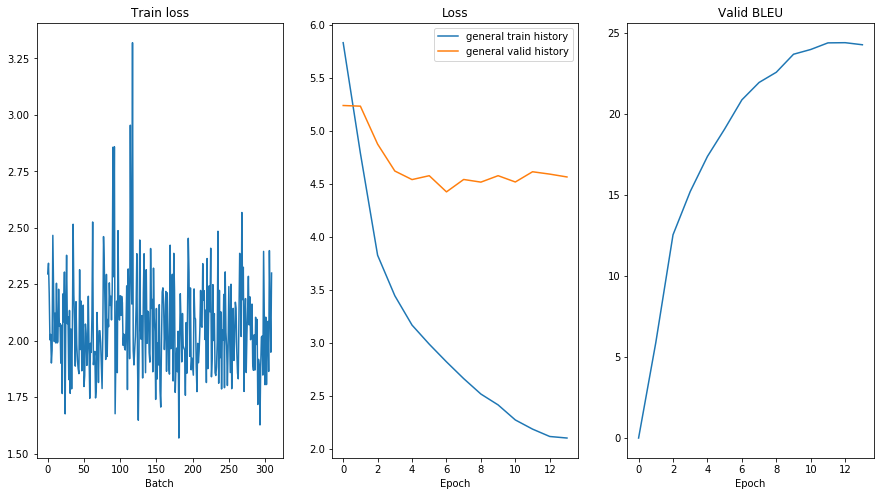

20it [00:00, 21.73it/s]


Epoch: 15 | Time: 1m 15s
	Train Loss: 2.062 | Train PPL:   7.860
	 Val. Loss: 4.580 |  Val. PPL:  97.549
	 Val. BLEU: 24.092


In [37]:
LR = 2e-3
N_EPOCHS = 15
CLIP = 1
MODEL_SAVE_PATH = 'GRU-enc-GRU-dec.pth'

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LR,
    epochs=N_EPOCHS,
    steps_per_epoch=len(train_iterator)
)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

train_history, valid_history, valid_bleu_history = run_train_loop(
    N_EPOCHS,
    CLIP,
    model,
    train_iterator,
    valid_iterator,
    optimizer,
    criterion,
    MODEL_SAVE_PATH,
    scheduler
)

In [38]:
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [39]:
calculate_bleu(model, test_iterator)

59it [00:03, 19.51it/s]


23.198345970122052

In [40]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: you will find a 24 - hour front desk at the property .
Generated: you will find a 24 - hour front desk at the property .

Original: a hairdryer can be requested .
Generated: hairdryers are available upon request .



GRU model has much better BLEU than the LSTM baseline (23.2 vs 15.3). Random samples from generated translations are good enough.

### 2. CNN encoder + GRU decoder

Now we'll replace GRU encoder with CNN.

In [59]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
GRU_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

KERNEL_SIZES = [3, 3]

enc = CNN_Encoder(
    INPUT_DIM,
    ENC_EMB_DIM,
    KERNEL_SIZES,
    HID_DIM,
    p=ENC_DROPOUT
)

dec = GRU_Decoder(
    OUTPUT_DIM,
    DEC_EMB_DIM,
    HID_DIM,
    GRU_LAYERS,
    p=DEC_DROPOUT
)

model = Seq2Seq(enc, dec, device).to(device)
model.apply(init_weights)

Seq2Seq(
  (encoder): CNN_Encoder(
    (embedding): Embedding(9240, 256)
    (dropout): Dropout(p=0.5, inplace=False)
    (convs): Sequential(
      (0): Sequential(
        (0): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
      )
      (1): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      (2): AdaptiveMaxPool1d(output_size=1)
    )
    (maxpool): AdaptiveMaxPool1d(output_size=1)
  )
  (decoder): GRU_Decoder(
    (embedding): Embedding(6717, 256)
    (dropout): Dropout(p=0.5, inplace=False)
    (rnn): GRU(256, 512, num_layers=2, dropout=0.5)
    (fc): Linear(in_features=512, out_features=6717, bias=True)
  )
)

In [60]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 11,470,141 trainable parameters


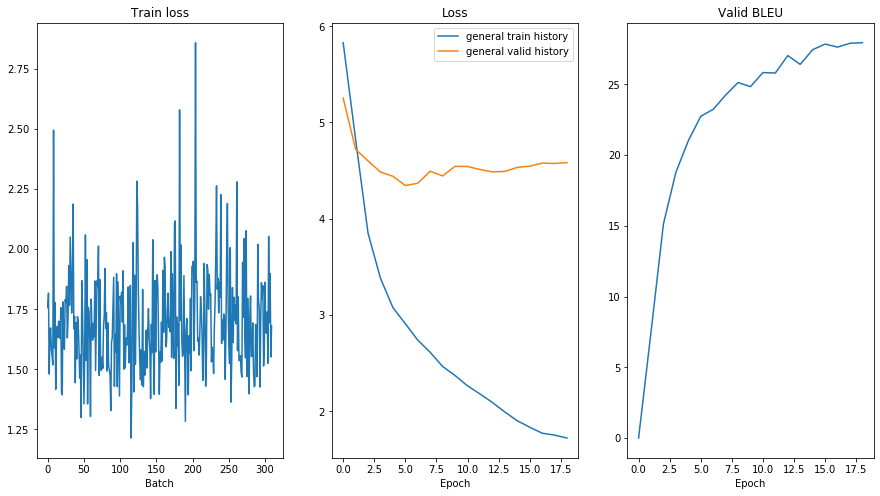

20it [00:01, 16.93it/s]


Epoch: 20 | Time: 1m 9s
	Train Loss: 1.694 | Train PPL:   5.439
	 Val. Loss: 4.587 |  Val. PPL:  98.204
	 Val. BLEU: 27.906


In [61]:
LR = 2e-3
N_EPOCHS = 20
CLIP = 1
MODEL_SAVE_PATH = 'CNN-enc-GRU-dec.pth'

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LR,
    epochs=N_EPOCHS,
    steps_per_epoch=len(train_iterator)
)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

train_history, valid_history, valid_bleu_history = run_train_loop(
    N_EPOCHS,
    CLIP,
    model,
    train_iterator,
    valid_iterator,
    optimizer,
    criterion,
    MODEL_SAVE_PATH,
    scheduler
)

In [62]:
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [63]:
calculate_bleu(model, test_iterator)

59it [00:02, 22.52it/s]


27.511415728699472

In [64]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: you will find a 24 - hour front desk at the property .
Generated: there is a 24 - hour front desk at the property .

Original: a hairdryer can be requested .
Generated: hairdryers can be requested upon request .



CNN encoder with GRU decoder scores BLEU=27.5 on test, but random generated translation sample looks not so good. Maybe we were unlucky.

### 3. CNN encoder + GRU decoder + attention

Let's add attention to our model:

In [65]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
GRU_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

KERNEL_SIZES = [3, 3]

enc = CNN_Encoder(
    INPUT_DIM,
    ENC_EMB_DIM,
    KERNEL_SIZES,
    HID_DIM,
    p=ENC_DROPOUT
)

dec = GRU_Decoder_With_Attention(
    OUTPUT_DIM,
    DEC_EMB_DIM,
    HID_DIM,
    GRU_LAYERS,
    p=DEC_DROPOUT
)

model = Seq2Seq(enc, dec, device).to(device)
model.apply(init_weights)

Seq2Seq(
  (encoder): CNN_Encoder(
    (embedding): Embedding(9240, 256)
    (dropout): Dropout(p=0.5, inplace=False)
    (convs): Sequential(
      (0): Sequential(
        (0): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
      )
      (1): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      (2): AdaptiveMaxPool1d(output_size=1)
    )
    (maxpool): AdaptiveMaxPool1d(output_size=1)
  )
  (decoder): GRU_Decoder_With_Attention(
    (embedding): Embedding(6717, 256)
    (dropout): Dropout(p=0.5, inplace=False)
    (rnn): GRU(256, 512, num_layers=2, dropout=0.5)
    (attention): Attention()
    (fc): Linear(in_features=1024, out_features=6717, bias=True)
  )
)

In [66]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,909,245 trainable parameters


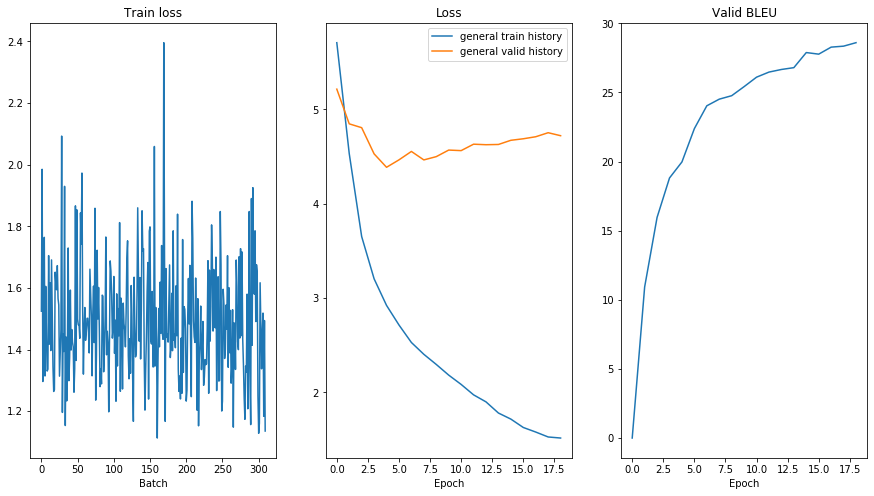

20it [00:01, 18.53it/s]


Epoch: 20 | Time: 1m 21s
	Train Loss: 1.488 | Train PPL:   4.428
	 Val. Loss: 4.737 |  Val. PPL: 114.142
	 Val. BLEU: 28.620


In [67]:
LR = 2e-3
N_EPOCHS = 20
CLIP = 1
MODEL_SAVE_PATH = 'CNN-enc-GRU-dec-with-attention.pth'

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LR,
    epochs=N_EPOCHS,
    steps_per_epoch=len(train_iterator)
)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

train_history, valid_history, valid_bleu_history = run_train_loop(
    N_EPOCHS,
    CLIP,
    model,
    train_iterator,
    valid_iterator,
    optimizer,
    criterion,
    MODEL_SAVE_PATH,
    scheduler
)

In [68]:
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [69]:
calculate_bleu(model, test_iterator)

59it [00:03, 18.53it/s]


27.884853565926893

In [70]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: you will find a 24 - hour front desk at the property .
Generated: there is a 24 - hour front desk at the property .

Original: a hairdryer can be requested .
Generated: hairdryers are available upon request .



Attention gives minor BLEU improvement (0.4) to model with CNN encoder.

### 4. GRU encoder + GRU decoder + attention

What if we use attention with GRU encoder?

In [53]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
GRU_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = GRU_Encoder(
    INPUT_DIM,
    ENC_EMB_DIM,
    HID_DIM,
    GRU_LAYERS,
    p=ENC_DROPOUT
)

dec = GRU_Decoder_With_Attention(
    OUTPUT_DIM,
    DEC_EMB_DIM,
    HID_DIM,
    GRU_LAYERS,
    p=DEC_DROPOUT
)

model = Seq2Seq(enc, dec, device).to(device)
model.apply(init_weights)

Seq2Seq(
  (encoder): GRU_Encoder(
    (embedding): Embedding(9240, 256)
    (dropout): Dropout(p=0.5, inplace=False)
    (rnn): GRU(256, 512, num_layers=2, dropout=0.5)
  )
  (decoder): GRU_Decoder_With_Attention(
    (embedding): Embedding(6717, 256)
    (dropout): Dropout(p=0.5, inplace=False)
    (rnn): GRU(256, 512, num_layers=2, dropout=0.5)
    (attention): Attention()
    (fc): Linear(in_features=1024, out_features=6717, bias=True)
  )
)

In [54]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 16,487,229 trainable parameters


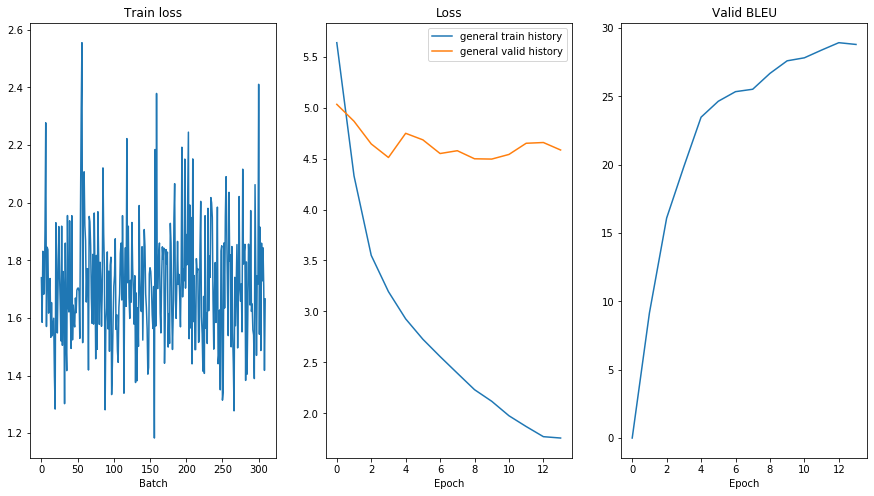

20it [00:01, 18.43it/s]


Epoch: 15 | Time: 1m 36s
	Train Loss: 1.712 | Train PPL:   5.541
	 Val. Loss: 4.601 |  Val. PPL:  99.537
	 Val. BLEU: 28.906


In [55]:
LR = 2e-3
N_EPOCHS = 15
CLIP = 1
MODEL_SAVE_PATH = 'GRU-enc-GRU-dec-with-attention.pth'

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LR,
    epochs=N_EPOCHS,
    steps_per_epoch=len(train_iterator)
)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

train_history, valid_history, valid_bleu_history = run_train_loop(
    N_EPOCHS,
    CLIP,
    model,
    train_iterator,
    valid_iterator,
    optimizer,
    criterion,
    MODEL_SAVE_PATH,
    scheduler
)

In [56]:
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [57]:
calculate_bleu(model, test_iterator)

59it [00:03, 18.59it/s]


28.37638586721351

In [58]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: you will find a 24 - hour front desk at the property .
Generated: you will find a 24 - hour front desk at the property .

Original: a hairdryer can be requested .
Generated: hairdryers hairdryers hairdryers upon request upon request .



Model with GRU encoder and GRU decoder with attention gives best score (BLEU 28.4), but random generated translation sample looks suspicious.

Maybe we were unlucky again :)

### Model comparsion

| Model                                    | Parameters | Training time (1 epoch) | BLEU |
|------------------------------------------|------------|-------------------------|------|
| LSTM encoder + LSTM decoder (baseline)   | 14.9M      | 80 s                    | 15.3 |
| GRU encoder + GRU decoder                | 13M        | 75 s                    | 23.2 |
| CNN encoder + GRU decoder                | 11.5M      | 69 s                    | 27.5 |
| CNN encoder + GRU decoder with attention | 14.9M      | 81 s                    | 27.9 |
| GRU encoder + GRU decoder with attention | 16.2M      | 96 s                    | 28.4 |

CNN encoder + GRU decoder gives good BLEU score and has the fastest training.

GRU encoder + GRU decoder with attention gives best BLEU score, but has the slowest training.